<a href="https://colab.research.google.com/github/marco-luzzara/boardgame-complexity-predictor/blob/master/src/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    !pip install -U scikit-learn
    from google.colab import drive
    drive.mount('/content/drive')

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
df_features.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 5.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Mounted at /content/drive


,averageweight,playingtime,rulebook_len,dice_luck_metric,drawing_luck_metric,shuffling_luck_metric,random_luck_metric,can_metric,choices_metric,entities_count,...,entities_variance,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,unspecified,wargames
0,2.1579,60,3155.0,0.0,0.000000,0.147710,0.000000,0.590842,0.295421,5.0,...,2.439704,0,0,0,1,0,0,0,0,0
1,3.1452,90,73093.0,0.0,0.013557,0.027113,0.027113,1.342100,0.135566,62.0,...,47.504669,0,0,0,0,0,1,0,0,0
2,1.8100,90,20155.0,0.0,0.000000,0.000000,0.000000,0.911927,0.143988,39.0,...,13.679672,0,0,0,0,0,0,1,0,0
3,1.4858,30,13866.0,0.0,0.413936,0.137979,0.000000,0.551914,0.275957,14.0,...,9.450702,0,0,0,1,0,0,0,0,0
4,2.7813,120,3604.0,0.0,0.000000,0.000000,0.000000,0.583090,1.020408,8.0,...,1.764098,0,0,0,0,0,1,0,0,0


In [10]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import StratifiedShuffleSplit

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def custom_cv_stratified_regression(fold_count: int, 
                                    x, y, 
                                    train_size = None, test_size = None,
                                    random_state = None) -> Generator[Tuple[List[int], List[int]], None, None]:
    splitter = StratifiedShuffleSplit(n_splits=fold_count, 
                                      train_size = train_size, test_size = test_size,
                                      random_state = random_state)
    # avg * 2 gives at most 10 classes
    weights_categories = y.squeeze().apply(lambda avg: round(avg * 2))
    for train_indices, test_indices in splitter.split(x, weights_categories):
        yield train_indices, test_indices

def train_test_stratified_split(x, y, 
                                train_size = None, test_size = None,
                                random_state = None):
    splitter = custom_cv_stratified_regression(1, x, y, 
                                               train_size, test_size, random_state = random_state)
    train_indices, test_indices = next(splitter)
    return x.iloc[train_indices], x.iloc[test_indices],\
           y.iloc[train_indices], y.iloc[test_indices]

class Model:
    def __init__(self, instance, params_tuning = None):
        self.instance = instance
        self.name = instance.__class__.__name__
        self.params_tuning = params_tuning

In [7]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List
from sklearn.metrics import PredictionErrorDisplay

MIN_COMPLEXITY, MAX_COMPLEXITY = 0, 5
MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def fill_predictions_subplot(ax, i_model: int, title: str, y_test, y_predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW

    subplot = ax[row][col]
    subplot.axis([MIN_COMPLEXITY, MAX_COMPLEXITY, MIN_COMPLEXITY, MAX_COMPLEXITY])
    subplot.grid(True)
    PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_predictions,
        kind="actual_vs_predicted",
        ax=subplot,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    subplot.set_title(title)

def create_containing_plot(plot_id: int, subplots_count): 
    containing_plot_rows = math.ceil(subplots_count / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - subplots_count):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

def create_header(text: str):
    display(widgets.HTML(
        value=f"<h1>{text}</h1>"
    ))

In [8]:
from collections import namedtuple
from typing import Tuple, Any
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV

PerformanceMetrics = namedtuple('PerformanceMetrics', ['r2', 'mae', 'mape', 'mse'])

# TODO: make cv_scoring assignment dynamic in performance metrics
def get_fit_estimator(estimator, x_train, y_train, splitter, cv_scorings) \
        -> Tuple[Any, PerformanceMetrics]:
    cv_results = cross_validate(estimator, 
                                x_train, y_train,
                                cv = splitter,
                                scoring = cv_scorings)
    estimator.fit(x_train, y_train)

    r2 = np.mean(cv_results['test_r2'])
    mae = np.mean(cv_results['test_neg_mean_absolute_error'])
    mape = np.mean(cv_results['test_neg_mean_absolute_percentage_error'])
    mse = np.mean(cv_results['test_neg_mean_squared_error'])
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics

def get_fit_estimator_with_tuning(estimator, params, x_train, y_train, \
                                  splitter, cv_scorings) -> Tuple[Any, PerformanceMetrics]:
    # refit needs an existing scoring
    assert 'neg_mean_absolute_error' in cv_scorings
    search = GridSearchCV(estimator,
                          params,
                          cv = splitter,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1, 
                          scoring = cv_scorings,
                          return_train_score = True)
            
    search.fit(x_train, y_train)
    estimator = search.best_estimator_

    r2, mae, mape, mse = search.cv_results_['mean_test_r2'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_absolute_percentage_error'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_]
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics

,Model,R2,MAE,MAPE,MSE
0,LinearRegression,0.620056,-0.370474,-0.172116,-0.225795
0,LassoCV,0.317666,-0.509153,-0.252614,-0.407067
0,ElasticNetCV,0.317540,-0.509193,-0.252638,-0.407143
0,RidgeCV,0.618753,-0.365916,-0.168313,-0.226624
0,BayesianRidge,0.614864,-0.358924,-0.163683,-0.229103


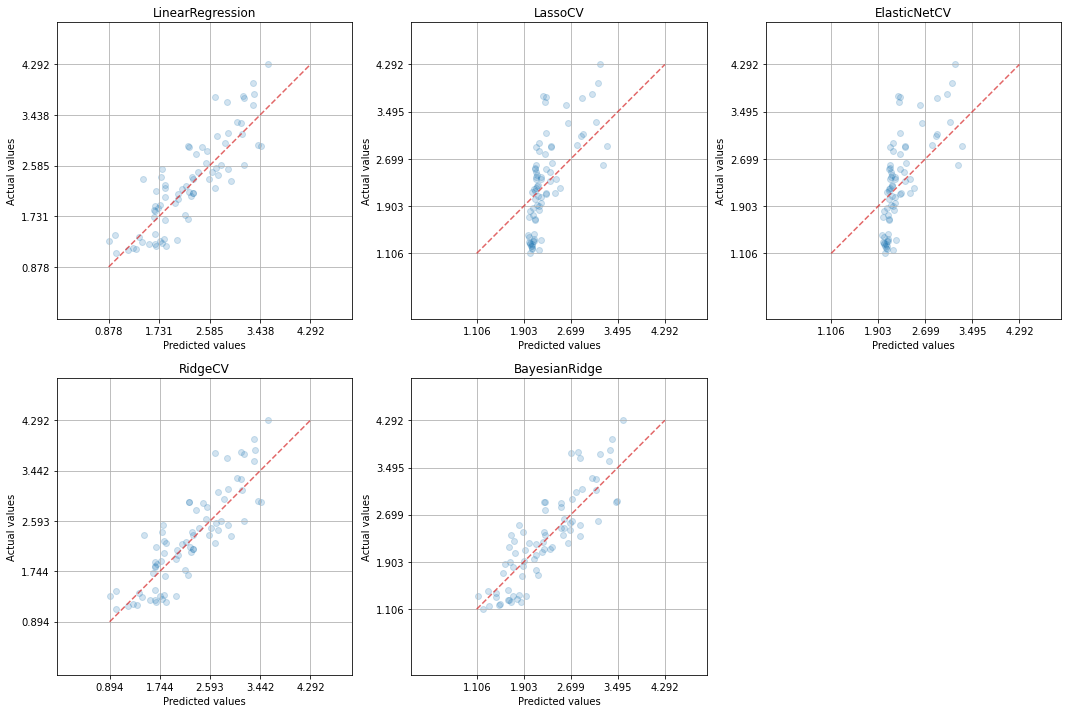

In [11]:
import numpy as np
from sklearn import linear_model, svm, kernel_ridge, neighbors, \
    gaussian_process, cross_decomposition, tree
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

models = {
    'Linear Models': [
        Model(linear_model.LinearRegression()),
        Model(linear_model.LassoCV()),
        Model(linear_model.ElasticNetCV()),
        Model(linear_model.RidgeCV()),
        Model(linear_model.BayesianRidge(), {
            'alpha_1': stats.gamma.rvs(1, size = 5), 'alpha_2': stats.gamma.rvs(1, size = 5), 
            'lambda_1': stats.gamma.rvs(1, size = 5), 'lambda_2': stats.gamma.rvs(1, size = 5), 
        }),
        # Model(linear_model.HuberRegressor()),
        # Model(linear_model.TweedieRegressor()),
        # Model(linear_model.QuantileRegressor())
    ],
    # 'Support Vector Machines': [Model(svm.SVR())],
    # 'Kernel Ridge': [Model(kernel_ridge.KernelRidge())],
    # 'Nearest Neighbors': [
    #     Model(neighbors.KNeighborsRegressor(weights='uniform')),
    #     Model(neighbors.KNeighborsRegressor(weights='distance'))
    # ],
    # 'Gaussian Process': [
    #     Model(gaussian_process.GaussianProcessRegressor())
    # ],
    # 'Cross Decomposition': [
    #     Model(cross_decomposition.PLSCanonical()),
    #     Model(cross_decomposition.PLSRegression()),
    #     Model(cross_decomposition.CCA()),
    # ],
    # # TODO: see ensemble methods
    # 'Decision Tree': [
    #     Model(tree.DecisionTreeRegressor()),
    #     Model(tree.ExtraTreeRegressor()),
    # ]
}

results = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MAPE', 'MSE'])
cv_scorings = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

x_train, x_test, y_train, y_test = \
    train_test_stratified_split(df_features.iloc[:, 1:], 
                                df_features.iloc[:, 0],
                                test_size = 0.20, random_state = 0)

for i_category, item in enumerate(models.items()):
    #create_header(item[0])
    fig, ax = create_containing_plot(i_category, len(item[1]))
    for i_m, model in enumerate(item[1]):
        splitter = custom_cv_stratified_regression(5, x_train, y_train, 
                                                   test_size = 0.20, random_state = 0)
        estimator, performanceMetrics = \
            get_fit_estimator(model.instance, x_train, y_train, splitter, cv_scorings) \
                if model.params_tuning is None else \
            get_fit_estimator_with_tuning(model.instance, model.params_tuning, 
                                          x_train, y_train, splitter, cv_scorings)

        y_predictions = estimator.predict(x_test)

        results = pd.concat([results, pd.DataFrame([
            { 
                'Model': model.name, 
                'R2': performanceMetrics.r2, 
                'MAE': performanceMetrics.mae, 
                'MAPE': performanceMetrics.mape,
                'MSE': performanceMetrics.mse
            }
            ])])
        fill_predictions_subplot(ax, i_m, model.name, y_test, y_predictions)

results